# NLP Assignment 2
Created by Prof. [Mohammad M. Ghassemi](https://ghassemi.xyz)

Submitted by: Safoora Masoumi

In collaboration with: <span style="color:red"> INSERT YOUR (OPTIONAL) HOMEWORK PARTNER'S NAME HERE </span>


<hr> 

## Assignment Goals
The goal of this assignment is to familiarize yourself with:

1. Parsing HTML data
2. Text classification using ngram language models
3. Text classification using supervised machine learning algorithms
4. Tools for sentiment analysis

The assignment combines tutorial components, with learning exercises that you must complete and submit. The learning exercise sections are clearly demarcated within the assignments.

## Before you start
1. PULL THE LATEST VERSION OF THE `course-materials` REPOSITORY, AND COPY `homework/HW2/` INTO THE CORRESPONDING DIRECTORY OF YOUR SUBMISSION FOLDER
2. CREATE AND ATTACH TO A VIRTUAL ENVIRONMENT, AND INSTALL THE REQUIREMENTS IN `requirements.txt`
3. IMPORT THE COURSE UTILITIES BY RUNNING THE CODE BLOCK BELOW

In [1]:
import re
import requests
import nltk
from nltk.util import ngrams
import requests
import time
import json
import math
import numpy as np
# Importing the `punkt` data, used by the NLTK tokenizer
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')


# An ngram extractor 
def extract_word_ngrams(data, num):
    n_grams = ngrams(nltk.word_tokenize(data), num)
    return [ ' '.join(grams) for grams in n_grams]


# Counts the frequency of token occurences in some text.
def CountFrequency(my_list): 
  
    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
    return freq




def basicLanguageModel(data, gram_size = 1):
    
    grams  = extract_word_ngrams(data,gram_size)
    #print(grams)
    counts = {}
    
    # -----------------------------------------------
    # Count the next gram, given the current gram:
    # -----------------------------------------------
    possible_nextgrams = len(list(set(grams)))
    for i in range(len(grams)-1):
        if grams[i] not in counts:
            counts[grams[i]]                     = {}
            counts[grams[i]]['___NUMBLANKGRAMS___'] = possible_nextgrams - 1
            counts[grams[i]][grams[i+1]] = 2   
        else:
            if grams[i+1] not in counts[grams[i]]:
                counts[grams[i]][grams[i+1]] = 1
                counts[grams[i]]['___NUMBLANKGRAMS___'] -= 1
            else:
                counts[grams[i]][grams[i+1]] += 1

    if grams[len(grams)-1] not in counts:
        counts[grams[len(grams)-1]] = {} 
        


    # -----------------------------------------------
    # convert the counts to probabilites and Laplacian Smooth
    # -----------------------------------------------
    probs = counts
    for key, value in counts.items():
        denominator = 0
        total_prob  = 0
        for key2, value2 in counts[key].items():      
            denominator += value2

        for key2, value2 in counts[key].items():
            if key2 != '___NUMBLANKGRAMS___':
                probs[key][key2] = value2 / denominator
                total_prob      += probs[key][key2]
        
        if '___NUMBLANKGRAMS___' not in counts[key]:
            counts[key]['___NUMBLANKGRAMS___'] = possible_nextgrams
            counts[key]['___BLANKUNITPROB___'] = 1/(possible_nextgrams)
        
        
        elif counts[key]['___NUMBLANKGRAMS___'] != 0:
            probs[key]['___BLANKUNITPROB___'] = (1-total_prob)/counts[key]['___NUMBLANKGRAMS___']
        else:
            probs[key]['___BLANKUNITPROB___'] = 0
      
    # -----------------------------------------------
    # Obtain the prior probabilities for each gram:
    # -----------------------------------------------
    gram_counts = CountFrequency(grams)
    count_total = sum(gram_counts.values())
    for key, value in gram_counts.items():
        probs[key]['___PRIOR___'] = value/count_total
        
    probs['___TOTALTOKENS___']  = len(grams)
    probs['___UNIQUETOKENS___'] = len(set(grams))
    return probs


# Generate a backoff model:
def trainBackoffModel(corpora, max_gram_size):
    langauge_model = []
    for gram_size in range(1,max_gram_size+1):
        langauge_model.append(basicLanguageModel(corpora, gram_size = gram_size))
    return langauge_model


# Returns the log probability of some new text, given the language model
def evaluateBackoffLangaugeModel(data, model, prior = True, verbose = False):

    # Begin by extracting a set of unigrams 
    segments      = extract_word_ngrams(data, 1)
    max_gram_size = min([len(segments), len(model)])

    segment_start = 0
    initial       = True
    log_prob      = 0
    complete      = False
    
    # Ideally, we would like to use the entire given segment, but if we can't find it
    # In the dictionary, we will back out, and check if we can find a match for a smaller
    # n-gram.
    while segment_start < (len(segments)-max_gram_size+1):
        
        found_match = False
        for i in range(max_gram_size):

            segment_end   = segment_start + (max_gram_size)
            given_segment = segments[segment_start+i:segment_end]
            given_gram    = ' '.join(given_segment)
            model_index   = max_gram_size-i-1
            if verbose == True:
                print('GIVEN GRAM:"', given_gram, '"')

            
            # We will check if this n-gram exists in the model
            if given_gram in model[model_index]:
                next_segment = segments[segment_start+i+1:segment_end+1]
                next_gram    = ' '.join(next_segment)
                if verbose == True:
                    print('NEXT GRAM:"', next_gram, '"')

                if next_gram in model[model_index][given_gram]:
                    
                    # Apply the prior probability
                    if initial == True and prior == True:
                        log_prob += math.log(model[model_index][given_gram]['___PRIOR___'])
                        initial  = False
                
                        if verbose == True:
                            print('log[p(' + given_gram + ')] = ' + str(log_prob))
                    
                    # Apply the conditional probability
                    if verbose == True:
                        print('log[p(' + next_gram + '|' + given_gram + ')] = ' + str(math.log(model[model_index][given_gram][next_gram])))
                        print('\n')
                        
                    log_prob += math.log(model[model_index][given_gram][next_gram])
                    found_match = True
                    break
                    
                else:
                    if verbose == True:
                        print('BACKING OFF: can not find match in dictionary for next gram "' + next_gram + '"')
                        print('\n')      

            else:
                if verbose == True:
                    print('BACKING OFF: can not find match in dictionary for given gram "' + given_gram + '"')
                    print('\n')
        
        # Laplacian Smoothing for next grams
        if found_match == False:
            if verbose == True:
                print('SMOOTHING: No match found, applying laplacian probability')
            
            # If the next-gram is missing:
            if given_gram in model[model_index]: 
                log_prob += math.log(model[model_index][given_gram]['___BLANKUNITPROB___'])
                if verbose == True:
                    print('log[p(' + next_gram + '|' + given_gram + ')] = ' + str(math.log(model[model_index][given_gram]['___BLANKUNITPROB___'])))
            
            # If the given gram is missing:
            else:
                log_prob += math.log(1 / (model[model_index]['___TOTALTOKENS___'] + 1))
                if verbose == True:
                    print('log[p(' + given_gram + ')] = ' + str(math.log(1 / (model[model_index]['___TOTALTOKENS___'] + 1))))
            
        segment_start+= 1
        
    return(log_prob)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sh.m\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<hr>

# Part 0: Collecting Data


This week, we will continue our journey through the text of the philosophers. More specifically, we'll be exploring how to use a natural language data for classification problems. To begin, let's return back to [Project Gutenburg](https://www.gutenberg.org/) and notice that the website not only provides us with access to the text of Bertrand's Russel's The Problem's of Philosophy, but also provides us with some interesting meta-data in the `Bibliographic Record` shown in the screen-shot below:

![Figure1](materials/images/Figure1.png)


Notice that the Bibliographic record provided by Project Gutenberg provides **classifications** of the books according their Library of Congress Class (`LOC Class`), as well as a `Subject`. As we discussed in the lectures, classifications are useful because they take our messy, continuous world and break it into manageable groupings that we can more easily act upon. Thanks to Project Gutenburg's classification, we can see that `The Problems of Philosophy` is a book about `Philosophy` (who would have guessed?!) and by knowing this classification we may (and most likely will) make some simplifying assumptions about the book without reading even a single line of it. 

It would be useful if we could collect this Bibliographic record, in addition to the information in the raw text itself. But in order for us to extract that information, we'll first need to obtain some practice processing, and extracting information from, HTML documents. If this is your first time looking at HTML documents and you would like to review how they are formatted, you can use [W3 Schools](https://www.w3schools.com/html/default.asp).

### Collecting and processing HTML data
Let's start by looking through some simple HTML documents for a mythical social network that I've stored locally in this respository (`materials/html/`): [Anqa.html](materials/html/Anqa.html), [Garuda.html](materials/html/Garuda.html), [Konrul.html](materials/html/Konrul.html), [Nue.html](materials/html/Nue.html) and [Simargl.html](materials/html/Simargl.html). You will notice that each HTML file simply contains a list of friends and enemies with links to other webpages. Here's what `Anqa.html` contains:

![Figure3](materials/images/Figure3.png)

And here is what gets displayed by the browser, using the HMTL file.

![Figure2](materials/images/Figure2.png)

To help us obtain some familiarity with parsing these types of documents, let's see if we can write some code to rank order these five mysterious figures based on the number of friends and enemies that they have mentioned in their web pages. The first step in that process will be to read the HTML pages into Python:

In [283]:
# A set of local HTML files
html_files = ['Anqa.html','Garuda.html','Konrul.html','Nue.html','Simargl.html']

# Read each file into a dictionary of HTML files
html = {}
for file in html_files:
    f = open(r'C:\Users\sh.m\Desktop\Python\Git\nlp-class\homework\HW2\materials\html\\' + file, 'r'); 
    html[file] = content = f.read(); 
    f.close() 

<br><br>We now have a dictionary containing each of the HTML files. Here's Anqa.html:

In [284]:
print('\n')
print(html['Anqa.html'])
print('\n')



<html>
<head><title>Anqa's Page</title></head>
<body>

<p class="friend"> My friends are:
<a href="/lab/tree/materials/html/Konrul.html" class="best"  id="link1">Konrul</a> and
</p>
    
<p class="enemy"> My enemies are:
<a href="/lab/tree/materials/html/Nue.html"  class="worst" id="link1">Nue</a>.
</p>

</body>
</html>




<br> The trick to extracting information from HTML documents is to look for a unified structure across documents that your parser can take advantage of. If we inspect the raw HTML of all five documents, we'll notice that they each contain a `<p class="friend">...</p>` and a `<p class="enemy">...</p>` section and that within those sections there are multiple `<a>` tags that list out the names, and links to the pages of, friends and enemies. To extract this information we can use some carefully crafted Regular Expressions!

In [285]:
print(html)
print(html.keys())
for page in html.keys():
    print(page)

{'Anqa.html': '<html>\n<head><title>Anqa\'s Page</title></head>\n<body>\n\n<p class="friend"> My friends are:\n<a href="/lab/tree/materials/html/Konrul.html" class="best"  id="link1">Konrul</a> and\n</p>\n    \n<p class="enemy"> My enemies are:\n<a href="/lab/tree/materials/html/Nue.html"  class="worst" id="link1">Nue</a>.\n</p>\n\n</body>\n</html>', 'Garuda.html': '<html>\n<head><title>Garuda\'s Page</title></head>\n<body>\n\n<p class="friend"> My friends are:\n<a href="/lab/tree/materials/html/Anqa.html" class="best"  id="link1">Anqa</a> and\n<a href="/lab/tree/materials/html/Nue.html"                id="link2">Konrul</a>.\n</p>\n    \n<p class="enemy"> My enemies are:\n<a href="/lab/tree/materials/html/Konrul.html"  class="worst" id="link1">Konrul</a>.\n</p>\n\n</body>\n</html>\n\n', 'Konrul.html': '<html>\n<head><title>Konrul\'s Page</title></head>\n<body>\n\n<p class="friend"> My friends are:\n<a href="/lab/tree/materials/html/Nue.html"                id="link2">Nue</a>.\n</p>\n  

In [286]:
import re
from pprint import pprint 

# Function to extract the friendship data from an HTML page 
def extractFriendData(html):
    _data = {}
    
    # Extract the friend and the enemy paragraphs:
    p_friend = re.findall(r'<p[^>]*class="friend"[^>]*>.*?</p>', html, re.DOTALL)[0]
    p_enemy  = re.findall(r'<p[^>]*class="enemy"[^>]*>.*?</p>' , html, re.DOTALL)[0]

    # Within each paragraph, find the href
    _data['friends'] = re.findall(r'>(Nue|Konrul|Garuda|Simargl|Anqa)<', p_friend, re.DOTALL)
    _data['enemies'] = re.findall(r'>(Nue|Konrul|Garuda|Simargl|Anqa)<', p_enemy, re.DOTALL)
    
    return _data

# Run the function for each page, and store results in a dictionary
data = {}
for page in html.keys():
    print(page.split('.')[0])
    data[page.split('.')[0]] = extractFriendData(html[page])

print('\n')
pprint(data)
print('\n')

Anqa
Garuda
Konrul
Nue
Simargl


{'Anqa': {'enemies': ['Nue'], 'friends': ['Konrul']},
 'Garuda': {'enemies': ['Konrul'], 'friends': ['Anqa', 'Konrul']},
 'Konrul': {'enemies': ['Anqa'], 'friends': ['Nue']},
 'Nue': {'enemies': [], 'friends': ['Simargl', 'Nue']},
 'Simargl': {'enemies': ['Nue'], 'friends': []}}




<br>Using the code block above, we are able to extract the structured data from the set of HTML documents. From here, it won't take much work to understand who has the most friends, and who has the most enemies in our mythical social network: 


In [287]:
friends, enemies = [], []
for page in data:
    friends += data[page]['friends']
    enemies += data[page]['enemies']

print('Friendship counts:'); pprint(CountFrequency(friends)); print('\n')
print('Enemy counts:'); pprint(CountFrequency(enemies)); print('\n')

Friendship counts:
{'Anqa': 1, 'Konrul': 2, 'Nue': 2, 'Simargl': 1}


Enemy counts:
{'Anqa': 1, 'Konrul': 1, 'Nue': 2}




In [288]:
from bs4 import BeautifulSoup
import json
import requests
import time

# Gets a book and meta-data from Project Guttenburg and saves the results to disk:
def getGutenburgBooks(urls, savedir=r'F:\Python\Git\nlp-class\homework\HW2\materials\data', sleep_time = 2):
    for url in urls:

        time.sleep(sleep_time/2)
        book = {}
         
        #-------------------------------------------------------------------------
        # Get raw HTML data:
        #-------------------------------------------------------------------------
        html   = requests.get(url).text                         # Get the raw HTML  
        soup   = BeautifulSoup(html,features="html.parser")     # Format the raw html
        files  = soup.find("table", attrs={"class": "files"})   # Find the <table> in the html with class='files'
        bibrec = soup.find("table", attrs={"class": "bibrec"})  # Find the <table> in the HTML with class='bibrec'                

        #-------------------------------------------------------------------------
        # Get the text of the book:
        #-------------------------------------------------------------------------
        time.sleep(sleep_time/2)
        text_url = ['https://www.gutenberg.org' + record.get("href") for record in files.find_all("a") if ('.txt' in record.get("href") and 'zip' not in record.get("href"))][0]
        book['text'] = requests.get(text_url).content.decode("utf-8", "strict")

        #-------------------------------------------------------------------------
        # Parse the HTML to generate biblographic record:
        #-------------------------------------------------------------------------
        for record in bibrec.find_all("tr"):
            key   = record.th.text.replace('\n', ' ').strip()
            value = record.td.text.replace('\n', ' ').strip()
            if key in book:
                book[key] += [value]
            else:
                book[key] = [value]
        
        #-------------------------------------------------------------------------
        # Save the book to disk
        #-------------------------------------------------------------------------
        print('Saving ' + book['Title'][0])
        x = json.dumps(book)
        f    = open(savedir + book['Title'][0].replace(' ','_') + ".json","w")
        f.write(x)
        f.close()

<br><br>As shown above, the BeautifulSoup library takes in a `html` file, and creates `soup`: an object that comes built in with several useful features that allow us to parse the HTML more easily including a `.find` function. In our case, we can use `.find` to extract the two HTLM `tables` that contain a link to the text file (`class="files"`) and the bibliographic record (`class="bibrec"`). Once we've extracted these tables, we can parse them to collect both the table, as well as the meta-data!

Let's run the tool to collect ten books from Project Gutenburg: 5 from Bertrand Russel, and 5 from Friedrich Nietzsche. 

In [ ]:
#
urls          = [ 'https://www.gutenberg.org/ebooks/44932','https://www.gutenberg.org/ebooks/25447',
                  'https://www.gutenberg.org/ebooks/2529','https://www.gutenberg.org/ebooks/690',
                  'https://www.gutenberg.org/ebooks/55610','https://www.gutenberg.org/ebooks/1998',
                  'https://www.gutenberg.org/ebooks/4363','https://www.gutenberg.org/ebooks/19322',
                  'https://www.gutenberg.org/ebooks/38145','https://www.gutenberg.org/ebooks/28146']

getGutenburgBooks(urls)

<br><br> The function saves all data in `json` format to `materials/data/`. Let's take a peak at the data in `On_the_Future_of_our_Educational_Institutions.json`:

In [289]:
# Open the book 
with open(r'C:\Users\sh.m\Desktop\Python\Git\nlp-class\homework\HW2\materials\data\\On_the_Future_of_our_Educational_Institutions.json') as f:
    book = json.load(f)

print('------------------------------------------------------------')    
print('Subject   - '   + ''.join(book['Title'])  + 
      '\nBy        - ' + ''.join(book['Author']) + 
      '\nLoC Class - ' + ';'.join(book['LoC Class']))
print('------------------------------------------------------------') 
print('**Sample Text**:' + book['text'][11012:11508] + '...')

------------------------------------------------------------
Subject   - On the Future of our Educational Institutions
By        - Nietzsche, Friedrich Wilhelm, 1844-1900
LoC Class - LB: Education: Theory and practice of education
------------------------------------------------------------
**Sample Text**:e especially against that flattering illusion
that our conditions should be regarded as the standard for all others
and as surpassing them. Let it suffice that they are our institutions,
that they have not become a part of ourselves by mere accident, and
were not laid upon us like a garment; but that they are living
monuments of important steps in the progress of civilisation, in some
respects even the furniture of a bygone age, and as such link us with
the past of our people, and are...


<br><br> Now let's separate the data by author into two corpora, one for `Nietzsche` and one for `Russel` and perform some basic cleaning on the text by removing non-ascii characters, and converting everything to lowercase.

In [2]:
from os import listdir
import json
# -----------------------------------------------
# Import the books
# -----------------------------------------------
books = listdir(r'C:\Users\sh.m\Desktop\Python\Git\nlp-class\homework\HW2\materials\data\\')
files = [r'C:\Users\sh.m\Desktop\Python\Git\nlp-class\homework\HW2\materials\data\\' + book for book in books if book[0] != '.']

data = []
for file in files: 
    with open(file) as f:
        x = json.load(f)
        data.append(x)
        
#print(data[0])
# -----------------------------------------------
# Merge the text from Nietzsche and Russel into two corpora
# -----------------------------------------------
Nietzsche, Russel = '', ''
for item in data:
    if 'Nietzsche' in item['Author'][0]:
        Nietzsche  += item['text'].replace(u'\xa0', u' ').replace(u'\ufeff', u' ').replace('_', ' ') + ' '
    if 'Russel'    in item['Author'][0]:
        Russel     += item['text'].replace(u'\xa0', u' ').replace(u'\ufeff', u' ').replace('_', ' ') + ' '

# -----------------------------------------------
# Keeping only the ascii charaacters
# -----------------------------------------------
Nietzsche = re.sub(r'[^\x00-\x7F]+','', Nietzsche)
Russel    = re.sub(r'[^\x00-\x7F]+','', Russel)  
    
# -----------------------------------------------
# Converting all words to lower case
# -----------------------------------------------    
Nietzsche  = Nietzsche.lower() 
Russel     = Russel.lower()


<hr>

# Part 1: Naive classification using ngram language models
Now that we have our text data imported and organized, let's try building a very simple author classification model; that is, we want to build a model that can predict the author of mysterious new sentences we have never seen before.  

Recall that in the last assignment, you trained two very simple `tri-gram` language models using the works of `Nietzsche` and `Russel`. As you saw, language models estimate the probability of a given ngram, or sequence of ngrams, according to the properties of the training data. Let's start this section of the tutorial by introducing a slightly more enhanced version of the `basicLanguageModel` that we covered in the last tutorial:

In [291]:
data        = "testing this testing this out testing testing"
grams  = extract_word_ngrams(data,1)
print(grams)

basic_model = basicLanguageModel(data, gram_size = 1)
print(basic_model)
print('-----------------------------------------------------------------------------------------------------------')
print('Langugage model structure for data: "testing this testing this out testing testing"')
print('-----------------------------------------------------------------------------------------------------------')
pprint(basic_model)

['testing', 'this', 'testing', 'this', 'out', 'testing', 'testing']
{'testing': {'___NUMBLANKGRAMS___': 1, 'this': 0.6, 'testing': 0.2, '___BLANKUNITPROB___': 0.19999999999999996, '___PRIOR___': 0.5714285714285714}, 'this': {'___NUMBLANKGRAMS___': 1, 'testing': 0.5, 'out': 0.25, '___BLANKUNITPROB___': 0.25, '___PRIOR___': 0.2857142857142857}, 'out': {'___NUMBLANKGRAMS___': 2, 'testing': 0.5, '___BLANKUNITPROB___': 0.25, '___PRIOR___': 0.14285714285714285}, '___TOTALTOKENS___': 7, '___UNIQUETOKENS___': 3}
-----------------------------------------------------------------------------------------------------------
Langugage model structure for data: "testing this testing this out testing testing"
-----------------------------------------------------------------------------------------------------------
{'___TOTALTOKENS___': 7,
 '___UNIQUETOKENS___': 3,
 'out': {'___BLANKUNITPROB___': 0.25,
         '___NUMBLANKGRAMS___': 2,
         '___PRIOR___': 0.14285714285714285,
         'testing': 0

<br><br> As you can see from the structure of the output above, our `basicLangaugeModel` is similar to the language model we demonstrated in the last tutorial, but has a couple of important modifications:

1. More computationally efficient because it doesn't keep track of (given ngram, next ngram) pairs with zero incidence.
2. The probabilities of the next ngram, given the current ngram are adjusted for a Laplacian smoothing assumption.
3. `___TOTALTOKENS___`: keeps track of the total tokens used in the training data
4. `___UNIQUETOKENS___`: keeps track of the number of unique tokens in the training data 
5. For each given ngrams, we provide:
    * `___PRIOR___` : absolute indicidence of the given ngram in the training data 
    * `___NUMBLANKGRAMS___`: number of `___UNIQUETOKENS___` that did not occur as next ngrams, for a given_gram 
    * `___BLANKUNITPROB___`: probability of a missing next ngram, assuming it occured only once; this is used for Laplacian smoothing.
   
We can validate that the language model is providing sensible values by checking that the sum of the `__PRIOR__` probabilities and the conditional probabilities sum to 1.


In [292]:
# Testing that the prior probabilties sum to 1
priors = []
for given_ngram in basic_model:
    if '___' not in given_ngram:
        priors.append(basic_model[given_ngram]['___PRIOR___'])
print('SUM OF NGRAM PRIOR PROBABILITIES:', sum(priors))

# Testing that the conditional probabilities sum to 1

#For a given ngram in the model
for given_ngram in basic_model:
    conditional = []
    if '___' not in given_ngram:
        for next_token in basic_model[given_ngram]:
            if '___' not in next_token:
                # Add the probabilities of the known next grams
                conditional.append(basic_model[given_ngram][next_token])
        
        # Add the probabilities of the missing next ngrams
        conditional.append(basic_model[given_ngram]['___BLANKUNITPROB___'] * basic_model[given_ngram]['___NUMBLANKGRAMS___'])
        print('SUM OF NEXT WORD PROBABILITIES, FOR GIVEN NGRAM "' + given_ngram + '": ', sum(conditional))

SUM OF NGRAM PRIOR PROBABILITIES: 1.0
SUM OF NEXT WORD PROBABILITIES, FOR GIVEN NGRAM "testing":  1.0
SUM OF NEXT WORD PROBABILITIES, FOR GIVEN NGRAM "this":  1.0
SUM OF NEXT WORD PROBABILITIES, FOR GIVEN NGRAM "out":  1.0


<br><br> One of the things that was discussed in Lecture 2 that we didn't get a chance to practice in the homework was `back-off` -  the strategy of using shorter ngrams when we can't find a match for a larger ngram. Building the components that support `back-off` is pretty straight forward; all we'll need to do is train is retrain our language model for various ngram sizes:

In [293]:
ngram_size    = 3 
Russel_lm     = trainBackoffModel(corpora = Russel   , max_gram_size = ngram_size)
Nietzsche_lm  = trainBackoffModel(corpora = Nietzsche, max_gram_size = ngram_size)
Russsel=basicLanguageModel(Russel)

<br><br> The `trainBackoffModel` function shown above is a simple `for` loop that trains 3 `basicLanguageModels` of varying gram sizes and stores them in a dictionary for later use. For instance, the `Russel_lm` contains our `basicLanguageModel` trained using the Russel corpus with n-grams of size 3, 2, and 1. We can see the n-gram language model conditional probabilities for `Russel` by simply indexing the list of models:

In [294]:
print('Conditional Probability from uigram language model: p(doctrine | this)')
print(Russel_lm[0]['this']['doctrine'],'\n')

print('Conditional Probability from bigram language model: p(doctrine may | this doctrine)')
print(Russel_lm[1]['this doctrine']['doctrine may'],'\n')

print('Conditional Probability from trigram language model: p(doctrine may be | this doctrine may)')
print(Russel_lm[2]['this doctrine may']['doctrine may be'],'\n')

Conditional Probability from uigram language model: p(doctrine | this)
0.0006556517178075007 

Conditional Probability from bigram language model: p(doctrine may | this doctrine)
9.20657717873649e-06 

Conditional Probability from trigram language model: p(doctrine may be | this doctrine may)
8.628834977845466e-06 



<br> Now that we've trained the our `basicLanguageModels`, we can use them to assess the probabilities of new sentences being generated by the `Russel` and `Nietzsche` language models.

In [295]:
# Test sentences:
sentences = ['attain salvation through reason', 
             'attain salvation through power',
             '______ salvation through power',
             'the mighty shall inherit the earth', 
             'contemplation may refine the mind',
             'contemplation may ______ the mind',]

# Predictions:
for sentence in sentences:
    r_logprob = evaluateBackoffLangaugeModel(sentence, Russel_lm)
    n_logprob = evaluateBackoffLangaugeModel(sentence,Nietzsche_lm)
    author = 'Russel' if r_logprob > n_logprob else 'Nietzsche'
    print('For the sentence: "', sentence, '". The Predicted authors is: ', author)
    

For the sentence: " attain salvation through reason ". The Predicted authors is:  Russel
For the sentence: " attain salvation through power ". The Predicted authors is:  Nietzsche
For the sentence: " ______ salvation through power ". The Predicted authors is:  Nietzsche
For the sentence: " the mighty shall inherit the earth ". The Predicted authors is:  Nietzsche
For the sentence: " contemplation may refine the mind ". The Predicted authors is:  Russel
For the sentence: " contemplation may ______ the mind ". The Predicted authors is:  Russel


<br><br> Notice here that because of back-off and Laplacian smoothing, our model is robust to missing terms such as the long `______` segments I inserted into the sample sentences. If you have some familiarity with the works of `Russel` and `Neitzsche` these sample sentence results will intuitively make sense and, at the surface, imply that we can directly use our language models to discriminate between the authors!  But in order for us to really understand how well these models can discriminate between the works of Russel and Neitzsche, we'll need to formally test our models on some data that we didn't use when training the models. That's where you come in. 

<hr> 

## Learning Exercise 1: 
#### Worth 1/5 Points

#### A. Retrain the Language Models using 80% of the data:
As we've discussed in the lectures, it is common practice to use 80% of one's data for model training and to test the performance of our models on the remaining 20% of the data that was held out. For this learning exercise, you will retrain the `Russel` and `Neitzsche` language models (tri-gram, with back-off) from Part 1 of the tutorial using 4/5 of the books from each author. You are welcome to use any code from this tutorial, including any functions in `materials/code/utils.py`

In [9]:
from os import listdir
import json
# -----------------------------------------------
# Import the books
# -----------------------------------------------
books = listdir(r'C:\Users\sh.m\Desktop\Python\Git\nlp-class\homework\HW2\materials\data\\')
files = [r'C:\Users\sh.m\Desktop\Python\Git\nlp-class\homework\HW2\materials\data\\' + book for book in books if book[0] != '.']

data = []
for file in files: 
    with open(file) as f:
        x = json.load(f)
        data.append(x)



Nietzsche, Russel,Nietzschetst, Russeltst  = '', '','',''
Niet=0
Russ=0 
for item in data:
    if Niet<4:
        if 'Nietzsche' in item['Author'][0]:
            Nietzsche  += item['text'].replace(u'\xa0', u' ').replace(u'\ufeff', u' ').replace('_', ' ') + ' '
    if Niet>=4:
        if 'Nietzsche' in item['Author'][0]:   
            Nietzschetst  += item['text'].replace(u'\xa0', u' ').replace(u'\ufeff', u' ').replace('_', ' ') + ' '
    if 'Nietzsche' in item['Author'][0]:        
        Niet+=1

    
    if Russ<4:
        if 'Russel'    in item['Author'][0]: 
            Russel     += item['text'].replace(u'\xa0', u' ').replace(u'\ufeff', u' ').replace('_', ' ') + ' '
    if Russ>=4:
        if 'Russel'    in item['Author'][0]:
            Russeltst  += item['text'].replace(u'\xa0', u' ').replace(u'\ufeff', u' ').replace('_', ' ') + ' '
    if 'Russel'    in item['Author'][0]:        
        Russ +=1  
    

Nietzsche = re.sub(r'[^\x00-\x7F]+','', Nietzsche)
Russel    = re.sub(r'[^\x00-\x7F]+','', Russel)  
Nietzschetest = re.sub(r'[^\x00-\x7F]+','', Nietzschetst)
Russeltest    = re.sub(r'[^\x00-\x7F]+','', Russeltst)  

Nietzschetr  = Nietzsche.lower() 
Russeltr     = Russel.lower()
Russeltests   = Russeltest.lower() 
Nietzschetests  = Nietzschetest.lower() 


In [11]:

ngram_size    = 3 
Russel_lmtr     = trainBackoffModel(corpora = Russeltr, max_gram_size = ngram_size)
Nietzsche_lmtr = trainBackoffModel(corpora = Nietzschetr, max_gram_size = ngram_size)


#### B. Test your Language Models on the remaining 20% of the data:
Evaluate the performance of the language models you trained in Part A of the learning exercise on the 2 books in your testing set (i.e. the two books we didn't use to train your model). More specifically, split the the testing set into a list of sentences and use the model to obtain the log probabilities for each sentence according to the `Russel` and `Neitzsche` models. Display these probabilities as four histograms using `matplotlib`. That is, your four plots should show:

1. The probabilities of the Russel test data according to the Russel model
2. The probabilities of the Russel test data according to the Neitzsche model
3. The probabilities of the Neitzsche test data according to the Russel model
4. The probabilities of the Neitzsche test data according to the Neitzsche model

In [12]:
Russelt=re.sub("\s+", " ", Russeltests)
Nietzschet=re.sub("\s+", " ", Nietzschetests)
Russelsent = nltk.sent_tokenize(Russelt)
Nietzschesent = nltk.sent_tokenize(Nietzschet)


#The probabilities of the Russel test data according to the Russel model
logprobRR=[]
for sentence in Russelsent:
    logprobrr= evaluateBackoffLangaugeModel(sentence, Russel_lmtr)
    logprobRR.append(logprobrr)
# The probabilities of the Russel test data according to the Neitzsche model
logprobRN=[]
for sentence in Russelsent:
    logprobrn = evaluateBackoffLangaugeModel(sentence, Nietzsche_lmtr)
    logprobRN.append(logprobrn)

#The probabilities of the Neitzsche test data according to the Russel model 
logprobNR=[]
for sentence in Nietzschesent:
    logprobnr = evaluateBackoffLangaugeModel(sentence, Russel_lmtr) 
    logprobNR.append(logprobnr)
    
#The probabilities of the Neitzsche test data according to the Neitzsche model 
logprobNN=[]
for sentence in Nietzschesent:
    logprobnn = evaluateBackoffLangaugeModel(sentence, Nietzsche_lmtr)
    logprobNN.append(logprobnn)


Text(0.5, 0, 'The probabilities of the Russel test data according to the Russel model')

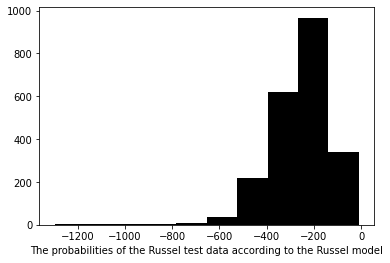

In [299]:
import matplotlib.pyplot as plt
plt.hist(logprobRR,color="k")
plt.xlabel('The probabilities of the Russel test data according to the Russel model')


Text(0.5, 0, 'The probabilities of the Russel test data according to the Neitzsche model')

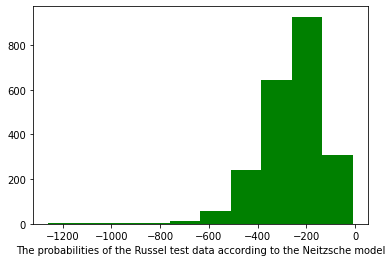

In [300]:
plt.hist(logprobRN,color="g")
plt.xlabel('The probabilities of the Russel test data according to the Neitzsche model')

Text(0.5, 0, 'The probabilities of the Neitzsche test data according to the Russel model')

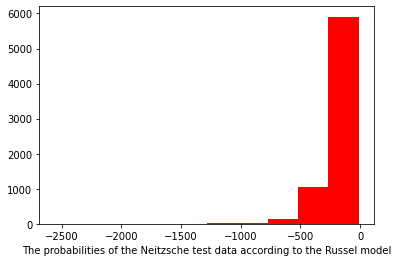

In [301]:
plt.hist(logprobNR,color="r")

plt.xlabel('The probabilities of the Neitzsche test data according to the Russel model')

Text(0.5, 0, 'The probabilities of the Neitzsche test data according to the Neitzsche model')

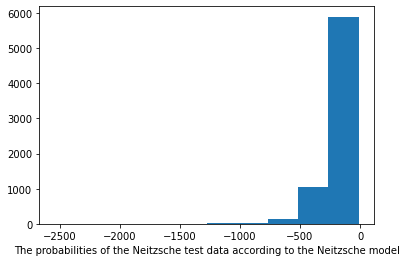

In [302]:
plt.hist(logprobNN)
plt.xlabel('The probabilities of the Neitzsche test data according to the Neitzsche model')

#### C. Interpretation of results:
Plese comment on any notable differences you see between the empirical distributions from part B. Speculate on why those differences might exist and what the results imply about the ability of the language models (in their current form) to classify new unseen sentences as belonging to `Russel` or `Neitzsche`  

######   It seems that the sentences of Russel  books is much more than Neitzsche. I assume that when we use the specific model to each author,the higher number of sentences with higher probabilty will be detected .However the difference between two Nietzche test datset is trivial

<hr>

# Part 2: Better Classification using N-gram Language Models
In the previous section we used two language models trained on two seperate corpora to classify if new sentences we had never seen before may have come from `Neitzsche` or `Russel`. One deficiency of the our previous approach is that our language models were trained to model the language they observed in their respective training datasets, not to formally discriminate between the authors of the texts! For this reason, it may not be fair to directly compare the probabilities from one model to another.

To illustrate, let us consider the following example using the same `BackoffLanguageModel` from the previous part of this tutorial:

In [22]:
ngram_size  = 1 

# train model x
data_x      = "I do not care about applications a"
model_x     = trainBackoffModel(data_x   , ngram_size)
#print(model_x)
# train model y
data_y      = "I I I I I I do not care about applications x y z "
model_y     = trainBackoffModel(data_y   , ngram_size)

test_sentence = "do not care"
prob_x = evaluateBackoffLangaugeModel(test_sentence, model_x)
prob_y = evaluateBackoffLangaugeModel(test_sentence, model_y)
print('FOR TEST SENTENCE: ', test_sentence)
print('MODEL X: log[p("'+ test_sentence + '")] = ', prob_x) 
print('MODEL Y: log[p("'+ test_sentence + '")] = ', prob_y) 

FOR TEST SENTENCE:  do not care
MODEL X: log[p("do not care")] =  -6.797940412974931
MODEL Y: log[p("do not care")] =  -8.160518247477505


<br><br>Whoa! What's going on here? Why is there such a difference between the models for the test sentence `do not care` when it shows up once and only once in both training corpora? Let's take a peek at the probabilities for a given uni-gram to see if we can discover what might be happening here:

In [23]:
print('MODEL X:')
pprint(model_x[0]['do'])

print('\nMODEL Y:')
pprint(model_y[0]['do'])

MODEL X:
{'___BLANKUNITPROB___': 0.125,
 '___NUMBLANKGRAMS___': 6,
 '___PRIOR___': 0.14285714285714285,
 'not': 0.25}

MODEL Y:
{'___BLANKUNITPROB___': 0.1,
 '___NUMBLANKGRAMS___': 8,
 '___PRIOR___': 0.07142857142857142,
 'not': 0.2}


<br><br> It seems that the probability of the uni-gram `not` given the uni-gram `do` is different for models X and Y. The reason for this difference is because the vocabulary size (the number of unique uni-grams) for the language models is different and hence, the Laplacian smoothing has a different impact on the conditional probabilities of the uni-grams! That is, the training data for `model_x` had 7 `___UNIQUETOKENS___`, while the training data for `model_y` had 9 `___UNIQUETOKENS___` - more unseen uni-grams means more probability density allocated to the unseen uni-rgams, at the cost of the probability density allocated to the seen uni-grams. Let's assume that we adjust for this by adding in the missing tokens from one data set, into the other.

In [13]:
ngram_size  = 1 

# train model x
data_x      = "I do not care about applications a"
data_y      = "I I I I I I do not care about applications x y z "

x_grams = extract_word_ngrams(data_x,1)
y_grams = extract_word_ngrams(data_y,1)
missing_from_x = list(set(x_grams + y_grams) - set(x_grams))
missing_from_y = list(set(x_grams + y_grams) - set(y_grams))

print('Vocabulary Missing from data_x')
print(missing_from_x)

print('\nVocabulary Missing from data_y')
print(missing_from_y)

Vocabulary Missing from data_x
['y', 'x', 'z']

Vocabulary Missing from data_y
['a']


<br><br> Now that we know what's missing, let's append those terms to the end of the data accordingly and re-compare the probability of the next uni-gram being `not` for a given uni-gram `do`: 

In [15]:
from pprint import pprint 

data_x  = "I do not care about applications a "         + " ___END___ " + " ___END___ ".join(missing_from_x)
data_y  = "I I I I I I do not care about applications x y z " + " ___END___ " + " ___END___ ".join(missing_from_y)

model_x     = trainBackoffModel(data_x   , ngram_size)
model_y     = trainBackoffModel(data_y   , ngram_size)

test_sentence = "do not care"
prob_x = evaluateBackoffLangaugeModel(test_sentence, model_x)
prob_y = evaluateBackoffLangaugeModel(test_sentence, model_y)

print('MODEL X:')
pprint(model_x[0]['do'])

print('\nMODEL Y:')
pprint(model_y[0]['do'])

print(model_x[0]['___TOTALTOKENS___'])
print(model_y[0]['___TOTALTOKENS___'])

MODEL X:
{'___BLANKUNITPROB___': 0.08333333333333334,
 '___NUMBLANKGRAMS___': 10,
 '___PRIOR___': 0.07692307692307693,
 'not': 0.16666666666666666}

MODEL Y:
{'___BLANKUNITPROB___': 0.08333333333333334,
 '___NUMBLANKGRAMS___': 10,
 '___PRIOR___': 0.0625,
 'not': 0.16666666666666666}
13
16


<br><br> That's better! But there's still another critical difference here. Notice that the prior probability is lower in `model_y` than it is in `model_x`. This is, once again, because models x and y have a different number of total words in their training data sets (7 in x, 11 in y). If we are ok eliminating this prior information, we can compare the model only according to their conditional probabilities by simply dividing out the prior from the results (i.e. by setting `prior=False` in my `utils.evaluateBackoffLangaugeModel`):

In [26]:
#importlib.reload(utils)

import math

data_x  = "I do not care about applications a "+ " ___END___ " + " ___END___ ".join(missing_from_x)
print(data_x)
data_y  = "I I I I I I do not care about applications x y z " + " ___END___ " + " ___END___ ".join(missing_from_y)

model_x     = trainBackoffModel(data_x   , 1)
model_y     = trainBackoffModel(data_y   , 1)

test_sentence = "do not care"
prob_x = evaluateBackoffLangaugeModel(test_sentence, model_x, prior = False)
prob_y = evaluateBackoffLangaugeModel(test_sentence, model_y, prior = False) 

print('FOR TEST SENTENCE: ', test_sentence)
print('MODEL X: log[p("'+ test_sentence + '")] = ', prob_x) 
print('MODEL Y: log[p("'+ test_sentence + '")] = ', prob_y) 


I do not care about applications a  ___END___ x ___END___ y ___END___ z
FOR TEST SENTENCE:  do not care
MODEL X: log[p("do not care")] =  -6.068425588244111
MODEL Y: log[p("do not care")] =  -6.068425588244111


<hr> 

## Learning Exercise 2: 
#### Worth 1/5 Points

#### A. Retrain the Language Models using 80% of the data:
Repeat the procedure from Learning Exercise 1 A. after augmenting the vocabulary of the training data sets to include the missing tokens as shown in this section of the tutorial. Note: because our model uses back-off, you will need to include the missing tokens for each of the n-gram sizes within the corresponding training data sets. 

In [6]:
def extractngrams(data,num):  #extract all ngrams in the range of ngrams we set to
    vocabulary=[]
    for n in range(1,num+1):
        n_grams = ngrams(nltk.word_tokenize(data), n)
        vocab= [ ' '.join(grams) for grams in n_grams]
        #print(vocab)
        for i in vocab:
            vocabulary.append(i)
    return vocabulary


In [10]:

Nietzschetr  = Nietzsche.lower() 
Russeltr     = Russel.lower()
Russeltrain=re.sub("\s+", " ", Russeltr)
Nietzschetrain=re.sub("\s+", " ", Nietzschetr)
Russeltrained=extractngrams(Russeltrain,3)
Nietzschetrained=extractngrams(Nietzschetrain,3)
missingfrom_Russel_lmtr = list(set(Russeltrained+Nietzschetrained) - set(Nietzschetrained))
missingfrom_Nietzsche_lmtr = list(set(Russeltrained+Nietzschetrained) - set(Russeltrained))


In [11]:
data_R = Russeltrain+ " ___END___ " + " ___END___ ".join(missingfrom_Russel_lmtr)
data_N  = Nietzschetrain + " ___END___ " + " ___END___ ".join(missingfrom_Nietzsche_lmtr)
ngram_size    = 3 
model_R     = trainBackoffModel(data_R   , ngram_size)
model_N     = trainBackoffModel(data_N   , ngram_size)


#### B. Test your Language Models on the remaining 20% of the data:
Repeat the procedure from Learning Exercise 1 B. after excluding the prior probabilities of the initial n-gram as shown in this section of the tutorial. 

In [19]:
Russelt=re.sub("\s+", " ", Russeltests)
Nietzschet=re.sub("\s+", " ", Nietzschetests)
Russelsent = nltk.sent_tokenize(Russelt)
Nietzschesent = nltk.sent_tokenize(Nietzschet)


#The probabilities of the Russel test data according to the Russel model
logprobRRR=[]
for sentence in Russelsent:
    logprobrr= evaluateBackoffLangaugeModel(sentence, model_R,prior = False)
    logprobRRR.append(logprobrr)
# The probabilities of the Russel test data according to the Neitzsche model
logprobRNN=[]
for sentence in Russelsent:
    logprobrn = evaluateBackoffLangaugeModel(sentence,model_N,prior = False )
    logprobRNN.append(logprobrn)

#The probabilities of the Neitzsche test data according to the Russel model 
logprobNRR=[]
for sentence in Nietzschesent:
    logprobnr = evaluateBackoffLangaugeModel(sentence, model_R,prior = False) 
    logprobNRR.append(logprobnr)
    
#The probabilities of the Neitzsche test data according to the Neitzsche model 
logprobNNN=[]
for sentence in Nietzschesent:
    logprobnn = evaluateBackoffLangaugeModel(sentence, model_N,prior = False )
    logprobNNN.append(logprobnn)


Text(0.5, 0, 'The probabilities of the Russel test data according to the Russel model')

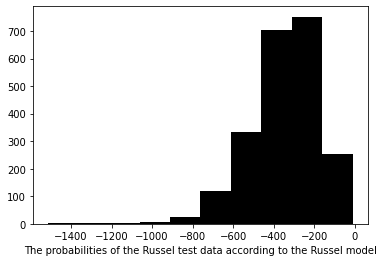

In [20]:
import matplotlib.pyplot as plt
plt.hist(logprobRRR,color="k")
plt.xlabel('The probabilities of the Russel test data according to the Russel model')


Text(0.5, 0, 'The probabilities of the Russel test data according to the Neitzsche model')

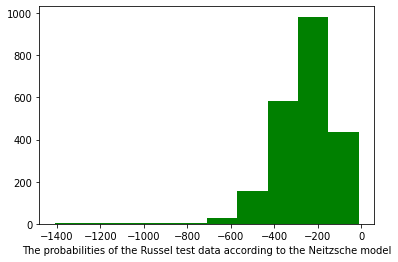

In [21]:
plt.hist(logprobRNN,color="g")
plt.xlabel('The probabilities of the Russel test data according to the Neitzsche model')

Text(0.5, 0, 'The probabilities of the Neitzsche test data according to the Russel model')

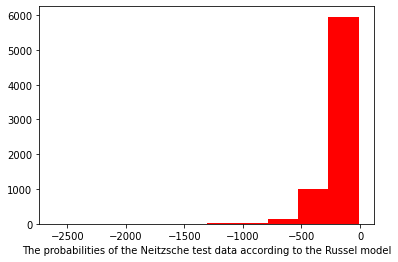

In [22]:
plt.hist(logprobNRR,color="r")

plt.xlabel('The probabilities of the Neitzsche test data according to the Russel model')

Text(0.5, 0, 'The probabilities of the Neitzsche test data according to the Neitzsche model')

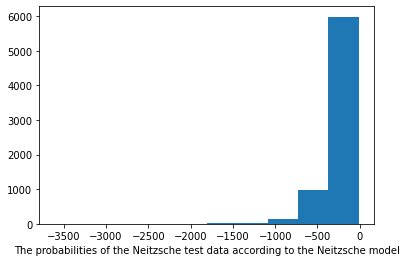

In [23]:
plt.hist(logprobNNN)
plt.xlabel('The probabilities of the Neitzsche test data according to the Neitzsche model')

#### C. Interpret Results:
Compare the distributions from Learning Exercise 1 part B. to the distributions from Learning Exercise 2 part B. Comment on any important differences, and if those differences are statistically significant. 

### I do not see any significant differences

#### D. Comparing Model Perplexity
As we discussed briefly in lecture 2, language models are usually assessed through their [perplexity](https://en.wikipedia.org/wiki/Perplexity). Create a function to compute the perplexity of the `basicLanguageModel` and compare the perplexity of the tri-gram `Russel` and `Neitzsche` models you trained in this section of the Learning Exercise.

In [24]:

ngram_size    = 3 
model_R     = trainBackoffModel(data_R   , ngram_size)
model_N     = trainBackoffModel(data_N   , ngram_size)


In [25]:

# compute the perplexity of the basicLanguageModel

def perplexity(model,data, gram_size = 1):
    grams  = extract_word_ngrams(data,gram_size)
    #print(grams)
    N=len(grams)
    perplexity=[]
    for word in grams:
        prob=model[word]
        for key,values in prob.items():
            perplex=1/values
            perplexity.append(perplex)
    for probabilities in perplexity:
        per=1
        per=per*probabilities
        finalperplexity=pow(per,1/N)
    return finalperplexity
    

In [26]:
#Because the trainBackoffModel result is a list,to extract the dictionary inside I use the [0] 
modeltrainedrussel=model_R[0]
modeltrainednitneitzsche=model_N[0]

@@@@ I could not perform this function on the dataset  with missing data,whenever I tried to do it my laptop stopped working,so I run the code in a more simple data,(it takes around 20 minutes).

In [ ]:
ngram_size    = 3 
R     = trainBackoffModel(Russeltrain   , ngram_size)
N     = trainBackoffModel(Nietzschetrain   , ngram_size)


In [ ]:
perplexity(R[0],Russeltrain, gram_size = 1)

1.0000127846173255

In [ ]:
perplexity(N[0],Nietzschetrain, gram_size = 1)

1.0000337536754893

<hr>

# Part 3: Classification using Classification Models
As we've seen together in the previous two sections of this tutorial, language models can be used for classification purposes by comparing the probability that a given sequence of text was generated by one author, versus another. But if our objective is to classify the author of a text, we need not spend so much time building a language model; instead we can focus our attention on the classification task directly. 

Let's return to the earlier task of sentence classification, starting with breaking our corpora into sentences.

In [13]:
import nltk

r_sentences = nltk.sent_tokenize(Russel)
n_sentences = nltk.sent_tokenize(Nietzsche)

print('Sentences in Nietzsche Books: ', len(n_sentences))
print('Sentences in Russel Books:    ', len(r_sentences))

print('------------------------------------------')
print('Here is an example sentence from Russel:')
print('------------------------------------------')
print(r_sentences[151])

Sentences in Nietzsche Books:  5892
Sentences in Russel Books:     8994
------------------------------------------
Here is an example sentence from Russel:
------------------------------------------
Both before and since,
one of the chief purposes of education in the United States has been to
turn the motley collection of immigrant children into good Americans.


### Bag of Words
As we discussed in the lectures, a bag-of-words is a simple way of representing a text document or segment as the count of the n-grams within it. With that in mind, let's convert the example sentence above into a bag-of-words representation:

In [304]:
unigram     = extract_word_ngrams(r_sentences[152],1)
bag_of_word = CountFrequency(unigram)

pprint(bag_of_word)

{',': 4,
 '.': 1,
 'American': 1,
 'Apparently': 1,
 'German': 1,
 'Japanese': 1,
 'a': 4,
 'any': 1,
 'bad': 1,
 'be': 1,
 'being': 1,
 'good': 3,
 'has': 1,
 'human': 1,
 'it': 1,
 'like': 1,
 'must': 1,
 'not': 1,
 'occurred': 1,
 'one': 1,
 'or': 1,
 'pro': 1,
 'tanto': 1,
 'that': 1,
 'to': 1}


<br><br> This tells us that the sentence we were just looking at consisted of 2 `,` uni-grams, 1 `.` uni-gram, and so on. Notice that converting a sentence to its bag-of-words representation eliminates information about the order of the words! That is, if I simply provided you this bag of words, you would have no way of (consistently) reconstructing the original sentence that was used to generate it. So why would anyone use a bag-of-words representation? Because it provides a simple way to convert our sentences into numerical vectors, for instance:

In [305]:
vector = list(bag_of_word.values())
print(vector)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


<br><br>Once we have transformed a string into a numerical vector, we can treat language like we would any other numerical object! That is, having all of our sentences represented as points in a vector space will allow us to do things like train models that can classify the authors of documents! 

But before we dive into classification using these vectors, we'll need to address a deficiency of the bag of words representation shown in the above example. Consider the fact that any given sentence is likely to only contain a small number of the total words in a given vocabulary. Consequently, if we want to compare two vectors, we'll need to keep track of both the words from the vocabulary that showed up, as well as those that did not! Here's how:

In [306]:
# Get all the distinct unigrams from the Russel books and the Nietzsche books and combine them
vocabulary    = list(set( extract_word_ngrams(Russel, 1) + extract_word_ngrams(Nietzsche, 1) ))

# Get the sentence I want to cast as bag of words:
unigram = extract_word_ngrams(r_sentences[152],1)

# Convert to bag of words:
tainted_bow  = CountFrequency(unigram + vocabulary)         # append the vocabulary to make sure it's counted
bag_of_words = {k: v - 1 for k, v in tainted_bow.items()}         # remove the counts that came from the vocabulary
vector       = list(bag_of_words.values())                        # cast to a vector


<br><br>The above code is not the most computationally efficient way to create the bag of words representation, but it's useful to help you understand exactly what a bag-of-words representation is capturing, and how it is generated. In reality, we would want to store our bag of words representation of the text in a sparse array instead of a memory-inefficient dictionary or list. Fortunately, there are Python packages that take care of creating bag-of-words representations in only a few lines of code. Let's use the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) function within Python's [Sklearn Library](https://scikit-learn.org/stable/) to convert the sentences we extracted earlier into their bag-of-words represenations:

<br><br>Note that the `CountVectorizer` object operates on the sentences themselves, performs the tokenization, and can even compute the representation for various n-gram sizes by setting `ngram_range` value of the function.

Now that we have a numerical representation of our text, we can start training machine learning algorithms with it. Recall from the lecture that supervised classification methods help our models learn a mathematical transformation of some given data, such as the words in a sentence, into some other data that we would like to make predictions about, such as the author of the sentence. We already created a numerical representation of the text, so all we need now is a numerical representation of the authors:

<hr>

# Learning Exercise 3:
### Worth 2/5 Points
As we discussed in the lectures, Naive bayes refers to a simple probabilistic classifier based on Bayes' theorem, with some strong independence assumptions about the conditional relationships between features. For this learning exercise you will explore the properties of Naive Bayes, and a few other classification models, given a bag of words representation of the text. 

#### A. Train and Assess a Naive Bayes Model
The code block below trains a Naive Bayes Model on 80% of the data from the tutorial, and tests the model on the remaining 20%. Please study and extend the code block provided below to:

1. Use bi-grams instead of unigrams as the "words" in the bag of words model
3. Perform 10-fold cross validation instead of an 80% - 20% validation
2. Report the mean and standard deviation of the following performance metrics across the ten validation folds:
    * accuracy, precision, recall and area under the reciever operator curve 

**PLEASE NOTE:** You must compute the accuracy, precision, recall, and area under the ROC curve using functions you write yourself, not functions from `sklearn`

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

######Unable to allocate 17.4 GiB for an array with shape (14886, 157046) and data type int64
#i got this error so i forced to reduce the size of the data
vectorizer = CountVectorizer(ngram_range=(2,2))
X          = vectorizer.fit_transform(r_sentences[:2000] + n_sentences[:2300])
X          = X.toarray()
import numpy as np

y = np.asarray([1 for i in range(0,len(r_sentences[:2000]))] + [0 for i in range(0,len(n_sentences[:2300]))])

In [15]:
from sklearn.naive_bayes     import MultinomialNB
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics         import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


kf = KFold(n_splits=10)
naive  = MultinomialNB()
cmx=[]
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    classifier = naive.fit(X_train,y_train)
    predict    = classifier.predict(X_test)
    cm         = confusion_matrix(y_test, predict)
    
    cmx.append(cm)
    


KeyboardInterrupt: 

In [ ]:
print(cmx)

In [309]:
cma=[]
for cm in cmx:
    tn, fp, fn, tp = cm.ravel()
    c=tn,fp,fn,tp
    cma.append(c)
print(cma)

[(0, 0, 158, 272), (0, 0, 85, 345), (0, 0, 61, 369), (0, 0, 47, 383), (111, 39, 25, 255), (289, 141, 0, 0), (225, 205, 0, 0), (320, 110, 0, 0), (309, 121, 0, 0), (136, 294, 0, 0)]


In [310]:

def Accuracy(cma):
    Accuracy=[]
    for tn,fp,fn,tp in cma:
        Acc=(tn+tp)/(tn+tp+fp+fn)
        Accuracy.append(Acc)
    return Accuracy
print(Accuracy(cma))
print(np.mean(Accuracy(cma)))
print(np.std(Accuracy(cma)))

[0.6325581395348837, 0.8023255813953488, 0.858139534883721, 0.8906976744186047, 0.8511627906976744, 0.672093023255814, 0.5232558139534884, 0.7441860465116279, 0.7186046511627907, 0.31627906976744186]
0.7009302325581396
0.1675684276169541


In [311]:
def Precision(cma):
    Precision=[]
    for tn,fp,fn,tp in cma:
        if tp==0:
            pre=0
        else:    
            pre=tp/(tp+fp)
        Precision.append(pre)
    return Precision
print(Precision(cma))
print(np.mean(Precision(cma)))
print(np.std(Precision(cma)))

[1.0, 1.0, 1.0, 1.0, 0.8673469387755102, 0, 0, 0, 0, 0]
0.48673469387755103
0.4881786650359186


In [313]:
def recall(cma):
    Recall=[]
    for tn,fp,fn,tp in cma:
        if tp==0:
            Re=0
        else:
            Re=tp/(tp+fn)
        Recall.append(Re)
    return Recall
print(recall(cma))
print(np.mean(recall(cma)))
print(np.std(recall(cma)))




[0.6325581395348837, 0.8023255813953488, 0.858139534883721, 0.8906976744186047, 0.9107142857142857, 0, 0, 0, 0, 0]
0.40944352159468445
0.41551925147264734


In [314]:

def FPR(cma):
    frr=[]
    for tn,fp,fn,tp in cma:
        if fp==0:
            fr=0
        else:
            fr=fp/(fp+tn)
        frr.append(fr)
    return frr 

TPR=recall(cma)
FPRR=FPR(cma)
print(TPR)
print(FPRR)


[0.6325581395348837, 0.8023255813953488, 0.858139534883721, 0.8906976744186047, 0.9107142857142857, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0.26, 0.32790697674418606, 0.47674418604651164, 0.2558139534883721, 0.2813953488372093, 0.6837209302325581]


In [315]:



def Auc(TPR,FPRR):
    auc=[]
    for x in TPR:
        for y in FPRR:
            aucc = -1 * np.trapz([x,y])
            auc.append(aucc)
        return auc
AUC=Auc(TPR,FPRR)
print(AUC)
print(np.mean(Auc(TPR,FPRR)))
print(np.std(Auc(TPR,FPRR)))

[-0.31627906976744186, -0.31627906976744186, -0.31627906976744186, -0.31627906976744186, -0.44627906976744186, -0.4802325581395349, -0.5546511627906977, -0.4441860465116279, -0.4569767441860465, -0.6581395348837209]
-0.43055813953488375
0.11091868693268389


<span style="color:red"> COMMENT ON YOUR RESULTS.</span>

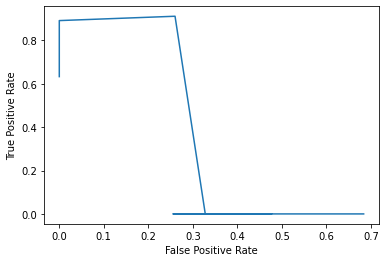

In [316]:
#ROC curve
plt.plot(FPRR,TPR)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#### B. Construct a dataset that highlights the limitations of Naive Bayes
Construct an example dataset of 10-20 sentences that highlights how the feature independence assumptions of Naive Bayes can lead to poor performance. Train Naive Bayes using the dataset you construct and comment on your results.

<span style="color:red"> COMMENT ON YOUR RESULTS</span>

#### C. Train other models and compare performance
Plot a [reciever operator curve](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/), and a [calibration plot](https://changhsinlee.com/python-calibration-plot/) for each models listed below trained on a given 80%-20% split of your data.

1. The Nieve Bayes classification model from part A.
3. Sklearn's implementation of [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)  with `none` as the penalty
4. Sklearn's implementation of [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with `elasticnet` as the penalty

Please plot the results in a way that makes it easy to compare the performance of the four models. If one of your models fails to converge due to [co-linearities](http://www.stat.tamu.edu/~hart/652/collinear.pdf), don't worry - simply report that in your results.

In [317]:
from sklearn.feature_extraction.text import CountVectorizer

######Unable to allocate 17.4 GiB for an array with shape (14886, 157046) and data type int64
#i got this error so i forced to reduce the size of the data
vectorizer = CountVectorizer(ngram_range=(2,2))
X          = vectorizer.fit_transform(r_sentences[:2000] + n_sentences[:2300])
X          = X.toarray()
import numpy as np

y = np.asarray([1 for i in range(0,len(r_sentences[:2000]))] + [0 for i in range(0,len(n_sentences[:2300]))])

In [318]:
from sklearn.naive_bayes     import MultinomialNB
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics         import confusion_matrix

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# initialize a Nieve bayes model
naive      = MultinomialNB()

# Fit the model using the training data
classifier = naive.fit(X_train,y_train)

# predict the author of the held-out test sentences
predict    = classifier.predict(X_test)

# generate the confusion matrix
cm         = confusion_matrix(y_test, predict)
tn, fp, fn, tp = cm.ravel()

# print the confusion matrix components
print('True Positives: ',  tp)
print('False Positives:',  fp)
print('True Negatives: ',  tn)
print('False Negatives:',  fn)



True Positives:  354
False Positives: 103
True Negatives:  358
False Negatives: 45


In [319]:
from sklearn.calibration import calibration_curve

prediction = classifier.predict_proba(X_test)
classifier_y, classifier_X= calibration_curve(y_test, prediction[:,1], n_bins=10)


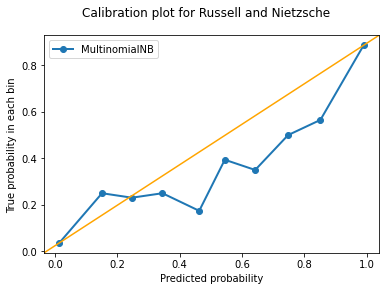

In [320]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(classifier_X,classifier_y, marker='o', linewidth=2, label='MultinomialNB')
line = mlines.Line2D([0, 1], [0, 1], color='orange')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for Russell and Nietzsche')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

#I think its impossible to create ROC for just one confusion matrix

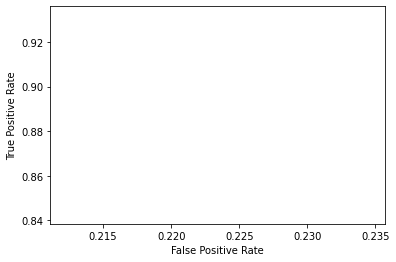

In [321]:
fpr=fp/(fp+tn)
tpr=tp/(tp+fn)
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

###create ROC and CP for  LogisticRegression with none as the penalty

In [322]:
from sklearn.feature_extraction.text import CountVectorizer

#i got the memory error so i forced to reduce the size of the data again
vectorizer = CountVectorizer(ngram_range=(2,2))
X          = vectorizer.fit_transform(r_sentences[:1800] + n_sentences[:1900])
X          = X.toarray()
import numpy as np

y = np.asarray([1 for i in range(0,len(r_sentences[:1800]))] + [0 for i in range(0,len(n_sentences[:1900]))])

In [323]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,StratifiedKFold



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

logreg_model = LogisticRegression(penalty='none').fit(X_train,y_train)
probs = logreg_model.predict_proba(X_test)
preds = probs[:,1]

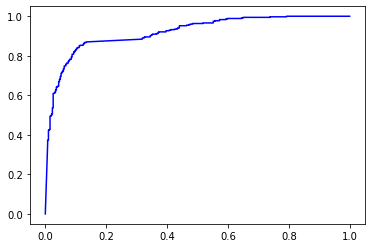

In [325]:
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)


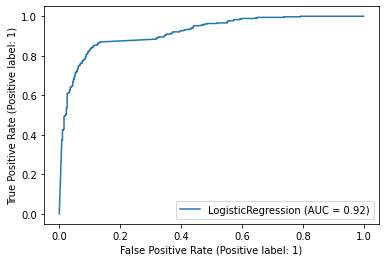

In [326]:
metrics.plot_roc_curve(logreg_model, X_test, y_test) 

<span style="color:red"> COMMENT ON ANY NOTABLE DIFFERENCES IN THE PERFORMANCE OF THE METHODS, AND DISCUSS WHY THESE DIFFERENCES MIGHT EXIST</span>

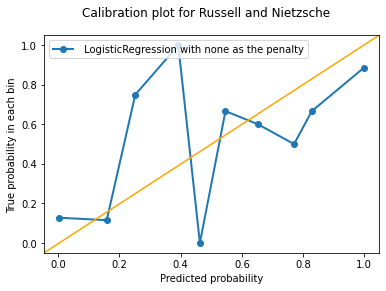

In [327]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms


logreg_model_y, logreg_model_X= calibration_curve(y_test, preds , n_bins=10)
fig, ax = plt.subplots()
plt.plot(logreg_model_X,logreg_model_y, marker='o', linewidth=2, label=' LogisticRegression with none as the penalty')
line = mlines.Line2D([0, 1], [0, 1], color='orange')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for Russell and Nietzsche')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

In [328]:
logreg_model = LogisticRegression( penalty='elasticnet',solver='saga',l1_ratio =0.5,max_iter=10000)


it seems that I have memory issues

In [ ]:
logreg_model.fit(X_train,y_train)

In [ ]:
probs = logreg_model.predict_proba(X_test)
preds = probs[:,1]

#### C. Explore the impact of vocabulary on model performance:
Repeat the procedure in part C after reducing the number of features in your bag of words. More specifically, regenerate the plots after removing:
* bottom 1% of ngrams by rank
* bottom 10% of ngrams by rank
* bottom 25% of ngrams by rank
* top 1% of ngrams by rank 
* top 10% of ngrams by rank 
* top 25% of ngrams by rank 

Comment on any differences you see in the results based on these changes and speculate on why the removal does (or does not) impact the results.

##i could not solve this part

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

#i have memory issue so i reduce the size
vectorizer = CountVectorizer(ngram_range=(2,2))
X          = vectorizer.fit(r_sentences[:1000] + n_sentences[:1100])
#print(X.vocabulary_)
y = np.asarray([1 for i in range(0,len(r_sentences[:1000]))] + [0 for i in range(0,len(n_sentences[:1100]))])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
xx=vectorizer.fit(r_sentences[:1000] + n_sentences[:1100])

In [ ]:
print(xx)

In [ ]:
XX.to_numpy()

In [ ]:
order = X.argsort()
ranks = order.argsort()

In [ ]:
print(ranks[:5])

In [ ]:
number=len(ranks)

In [ ]:
#find the 1,10,25 percebt bottom
#the number of elements to be removed
one=int(number/100)
ten=int(number/10)
twentyfive=int(number/4)

In [ ]:
np.delete(ranks,[0:one])

In [ ]:
from sklearn.naive_bayes     import MultinomialNB
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics         import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(One, y, test_size=0.2, random_state=123)

# initialize a Nieve bayes model
naive      = MultinomialNB()

# Fit the model using the training data
classifier = naive.fit(X_train,y_train)

# predict the author of the held-out test sentences
predict    = classifier.predict(X_test)

<hr>

# Part 4: Sentiment Classification
In the previous section of this assignment, we demonstrated how to train a model that classifies the author of a text using a bag-of-words. We were able to accomplish this task with relative ease using a supervised learning approach. 

The sentence-author classification problem we tacked in the last section was convenient because we could easily generate the labels for the training data sentences by simply referring back to the author of the book. That is, all sentences in a book are the product of the author, by definition. 

But not all classification problems in NLP are as straight forward as the author classification task we solved in the last section. What if we wanted to classify the sentences in `Russel` and `Nietzsche` according to their sentiment? What would we use for training data? Furthermore, sentiment is not binary; it exists on a spectrum. How would we account for that even if we were to label the sentences?  

One solution to this problem is to assign a sentiment value to individual words, and to then compute the sentiment of the text based on the properties of those word-level sentiment scores. 

Fortunately for us, there are resources that provide normalized estimates of word sentiment! One such resource is [SentiWordNet](https://github.com/aesuli/SentiWordNet). SentiWordNet assigns various words in the English language a `positive`, `negative`, and `objective` value score that is normalized between the range of 0 - 1 . You can download the SentiWordNet data from [this address](https://raw.githubusercontent.com/aesuli/SentiWordNet/master/data/SentiWordNet_3.0.0.txt), but I've also included a copy [locally here](materials/sentiwordnet/sentiwordnet.txt). Let's start by importing the data, formatting it and storing it in a dictionary called `sentiment`:

In [16]:
# IMPORT LIBRARY
import csv

# INIT DICT TO STORE WORDS AND THEIR SENTIMENT SCORES
sentiment = {}

# OPEN FILE
with open(r'C:\Users\sh.m\Desktop\sentiwordnet.txt', newline = '') as f:                                                                                          

    # POINT TO CONTENTS
    csvreader = csv.reader(f, delimiter='\t')
     
    # LOOP THROUGH EACH LINE
    for i, line in enumerate(csvreader):
        
        # GET HEADERS
        if i == 0:
            headers = line
        
        # OTHERWISE PROCESS DATA
        else:
        
            # WORD IS 4th COLUMN
            words = line[4]
            
            for word in words.split():
                # SAVE POS AND NEG SCORE OF WORD
                sentiment[word] = {'PosScore': line[2], 'NegScore': line[3]}

Now that it's imported, let's see what the sentiment value of the word `happy` is:

In [17]:
# FIND SCORE OF HAPPY 
print(sentiment["happy"+"#1"]) #1 MEANS ITS FIRST SENSE

{'PosScore': '0.875', 'NegScore': '0'}


And how about the word `sad`:

In [18]:
print(sentiment['sad#1']) #1 MEANS ITS FIRST SENSE

{'PosScore': '0.125', 'NegScore': '0.75'}


Because words are assigned both a positive an negative score, I can simplify this sentiment value down to a single number by taking the difference between the positive and negative sentiment values:

In [19]:
print(float(sentiment['sad#1']['PosScore']) - float(sentiment['sad#1']['NegScore'])) 

-0.625


# Learning Exercise 4:
### Worth 1/5 Points

#### A. Extract sentiment:
Use the word-level sentiment scores provided by SentiWordNet to assign a sentiment score to every word, in every sentence of the Russel and Nietzsche texts. For each sentence, sum the sentiment of all words in that sentence and divide by the total number of words in that sentence to create a single normalized sentiment value for each sentence. Generate two histogram that compares the empirical distribution of sentence sentiments for the two authors. Comment on any differences between the distributions. Are the differences statistically significant?

NOTE: For simplicity, please assume the first `sense` of the word in SentiWordNet, as shown in the tutorial example.

In [20]:
Russelt=re.sub("\s+", " ", Russeltests)
Nietzschet=re.sub("\s+", " ", Nietzschetests)
Russelsent = nltk.sent_tokenize(Russelt)
Nietzschesent = nltk.sent_tokenize(Nietzschet)
#print(Nietzschesent)

In [21]:
#cleaning the dataset

from nltk.corpus import stopwords

stopwords.words('english')
WordN=[]
for sentences in Nietzschesent:
    
    words = nltk.word_tokenize(sentences)
    tokens = [word for word in words if not word in stopwords.words('english')]
    wor = [word for word in tokens if word.isalpha()]
    WordN.append(wor)
    
FinalWordN = list(filter(None, WordN))     

In [22]:

stopwords.words('english')
WordR=[]
for sentences in Russelsent:
    
    words = nltk.word_tokenize(sentences)
    tokens = [word for word in words if not word in stopwords.words('english')]
    wor = [word for word in tokens if word.isalpha()]
    WordR.append(wor)
FinalWordR = list(filter(None, WordR))     

Use the word-level sentiment scores provided by SentiWordNet to assign a sentiment score to every word, in every sentence of the Russel and Nietzsche texts. For each sentence, sum the sentiment of all words in that sentence and divide by the total number of words in that sentence to create a single normalized sentiment value for each sentence. Generate two histogram that compares the empirical distribution of sentence sentiments for the two authors. Comment on any differences between the distributions. Are the differences statistically significant?

NOTE: For simplicity, please assume the first sense of the word in SentiWordNet, as shown in the tutorial example.

In [23]:
NNSV=[]
for lst in FinalWordN:
    
    num=len(lst)
    Mark=[]
    total=0
    
    for word in lst:
        words=word+"#1"
        if words in sentiment:
            mark=float(sentiment[words]['PosScore']) - float(sentiment[words]['NegScore'])
            total+=mark
            Mark.append(mark)
            
    nsv=total/num
    NNSV.append(nsv)


In [24]:
RNSV=[]
for lst in FinalWordR:
    
    num=len(lst)
    Mark=[]
    total=0
    
    for word in lst:
        words=word+"#1"
        if words in sentiment:
            mark=float(sentiment[words]['PosScore']) - float(sentiment[words]['NegScore'])
            total+=mark
            Mark.append(mark)
            
    nsv=total/num
    RNSV.append(nsv)


In [25]:

import numpy as np

def ecdf(RNSV):

    # convert sample to a numpy array, if it isn't already
    RNSV = np.atleast_1d(RNSV)

    # find the unique values and their corresponding counts
    quantiles, counts = np.unique(RNSV, return_counts=True)

    # take the cumulative sum of the counts and divide by the sample size to
    # get the cumulative probabilities between 0 and 1
    cumprob = np.cumsum(counts).astype(np.double) / len(RNSV)

    return quantiles, cumprob

In [26]:
Recdf=ecdf(RNSV)
#print(Recdf)
Necdf=ecdf(NNSV)

(array([[  7.,  58., 222., 105.,   9.,   1.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  57.,  56.,  46.,  31.,  37.,  44.,  47.,  84.]]),
 array([-0.325 , -0.1925, -0.06  ,  0.0725,  0.205 ,  0.3375,  0.47  ,
         0.6025,  0.735 ,  0.8675,  1.    ]),
 <a list of 2 BarContainer objects>)

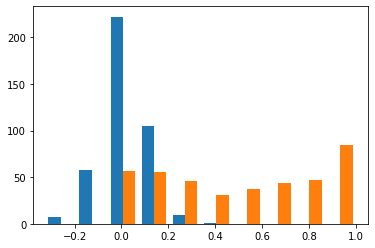

In [27]:
import matplotlib.pyplot as plt
plt.hist(Recdf)

(array([[  2.,   3.,   8.,  50., 325., 131.,  16.,   3.,   3.,   2.],
        [  0.,   0.,   0.,   0.,  63., 132.,  48.,  43., 107., 150.]]),
 array([-0.875 , -0.6875, -0.5   , -0.3125, -0.125 ,  0.0625,  0.25  ,
         0.4375,  0.625 ,  0.8125,  1.    ]),
 <a list of 2 BarContainer objects>)

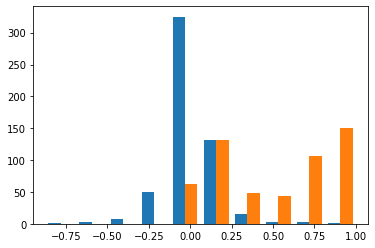

In [271]:
plt.hist(Necdf)


<span style="color:red"> INSERT AN INTERPRETATION OF YOUR RESULTS HERE </span>

#### B. Use of sentiment as a feature:
Train a logistic regression model which takes as input 
* a bag-of-words representation of the sentences (uni-grams) and 
* the sentence sentiment you just computed

to predict the identity of the author, just as we did in Learning Exercise 3. Compute the [odds ratio](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2938757/) of the coefficient that describes the importance of the sentiment feature, and interpret what the odds ratio means. If your model does not converge, use a coherent strategy to remove bag-of-words features until it does.

In [279]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,1))
X          = vectorizer.fit_transform(Russelsent + Nietzschesent)
X          = X.toarray()
import numpy as np

y = np.asarray([1 for i in range(0,len(Russelsent))] + [0 for i in range(0,len(Nietzschesent))])

<h1><span style="color:red"> Self Assessment </span></h1>
Please provide an assessment of how successfully you accomplished the learning exercises in this assignment according to the instruction provided; do not assign yourself points for effort. This self assessment will be used as a starting point when I grade your assignments. Please note that if you over-estimate your grade on a given learning exercise, you will face a 50% penalty on the total points granted for that exercise. If you underestimate your grade, there will be no penalty.

* Learning Exercise 1: 
    0.75/1 points
* Learning Exercise 2: 
    0.75/1 points
* Learning Exercise 3:
    * 1.25/2 points
* Learning Exercise 4:
    * 0.5/1 points

#### Total Grade: 
3.25/5